In [1]:
import MAIA
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import os

# Loading the Raw data

In [14]:
section = '8hpf/20230639_Zebrafish_ctrl_cl5_8hpf_section_9_167x182_Att35_5um'

path = '/data/SV_DAngelo/Leila/MALDI-MSI/MAIA_zebrafish/Atlases/Controls_timepoints/'

smz = MAIA.utils.SmzMLobj(f'{path+section}/{section[5:]}.IBD',
               f'{path+section}/{section[5:]}.imzml',
               mz_resolution=10e-5, selected_pixels=(0,10000)) #for section in sections]
       
smz.load(load_unique_mz=True)

Loading Spectra at resolution 0.0001: 100%|██████████| 10000/10000 [00:00<00:00, 15537.09it/s]
Loading the m/z values at resolution 0.0001: 10000it [00:00, 17276.59it/s]


# Peak Finder

In [4]:
mz_resolution = 0.0001
threshold_count = 8.
approximate_interval =1.5
smoothing = 1. #2.5

3000it [00:27, 108.61it/s]


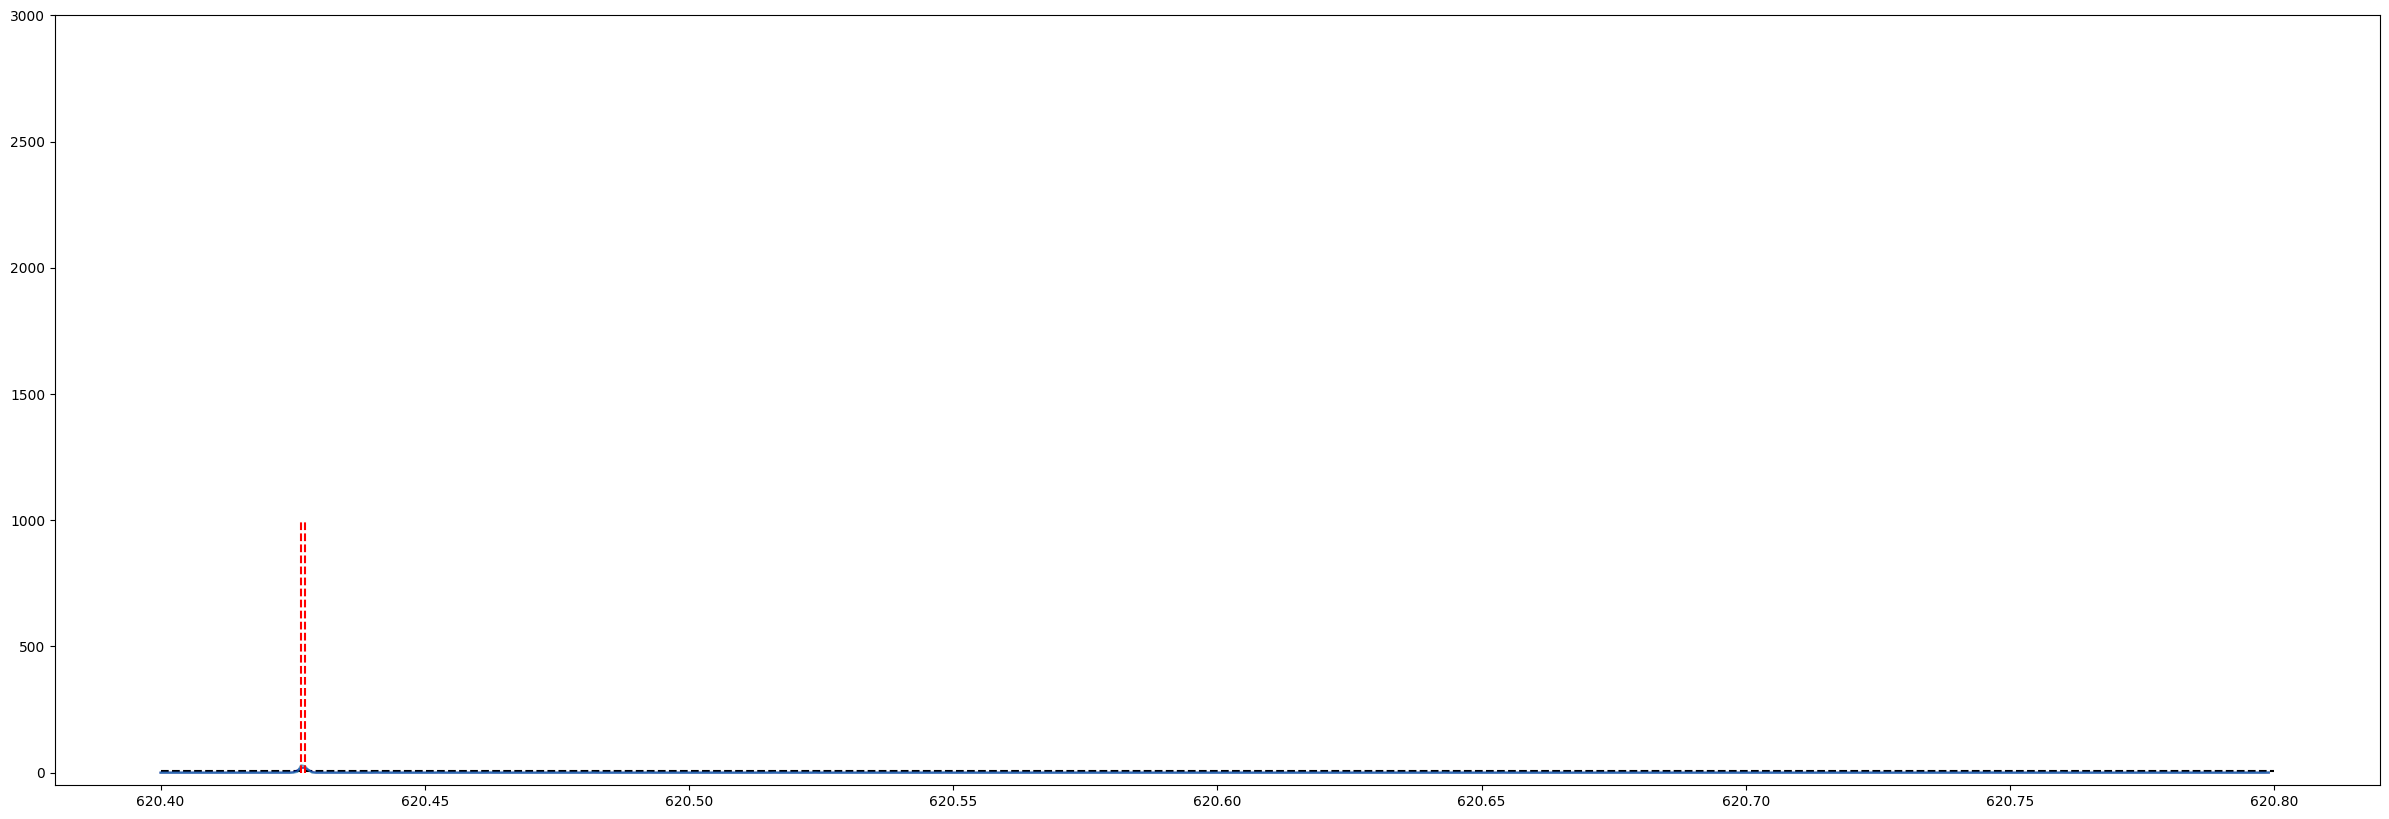

In [5]:
# mzrange_test =np.array([447.1, 447.4])
mzrange_test =np.array([620.4,620.8])
# mzrange_test =np.array([823.27, 823.38])

PF = MAIA.vis.plot_freqmz(smz, mzrange_test, bins=True,smoothing=smoothing, ylim=3000, threshold_count=threshold_count, approximate_interval=approximate_interval,
                                  parallelize=True, mz_resolution=mz_resolution)

for m in PF.data_mz[PF.seeds]:
    plt.vlines(m, 0,1000,linestyle='--', color='r')

In [15]:
MAIA.pf.run(directory_path=f'{path}{section}/CHECK/',
                smz=smz, spectrum_range=(400,1200), threshold_count=threshold_count, 
                approximate_interval=approximate_interval, parallelize=True, smoothing=smoothing, saveimages=True)

10000it [02:48, 59.36it/s]


Partioning m/z space and beginning peakcalling...
841398


100%|██████████| 107/107 [00:56<00:00,  1.90it/s]


Creating dataframe...


100%|██████████| 10430/10430 [00:14<00:00, 740.67it/s]


DataFrame created successfully
Removing temporary storage
Saving images...


100%|██████████| 10430/10430 [02:02<00:00, 85.23it/s]


Complete


### Visualization

# Molecular Matcher

In [3]:
path = '/data/SV_DAngelo/Leila/MALDI-MSI/MAIA_zebrafish/Atlases/Controls_timepoints/'
acquisitions = [
            #8hpf:
            '8hpf/20230639_Zebrafish_ctrl_cl5_8hpf_section_9_167x182_Att35_5um', 

            #24hpf:
            '24hpf/20230528_Zebrafish_ctrl_cl5_24hpf_section5_248x147_Att35_7um',

            #48hpf:
            '48hpf/20230528_Zebrafish_ctrl_cl5_48hpf_section14_362x159_Att35_7um',
            '48hpf/20230529_Zebrafish_ctrl_cl5_48hpf_section13_363x166_Att35_7um',

            #72hpf:
            '72hpf/20230530_Zebrafish_ctrl_cl5_72hpf_section_414x126_Att35_7um',
            '72hpf/20230601_Zebrafish_ctrl_cl5_72hpf_section16_427x129_Att35_7um'
           ]

ranges_files = [f'{path}{section}/ranges.csv' for section in acquisitions]
images_files = [f'{path}{section}/images.h5ad' for section in acquisitions]


df_list = MAIA.utils.tools.read_files(ranges_files)

In [4]:
df_match = MAIA.mm.match(MAX_DIST=0.005, df_list=df_list)

  0%|          | 0/800 [00:00<?, ?it/s]

Restricted license - for non-production use only - expires 2024-10-28


100%|██████████| 800/800 [01:41<00:00,  7.85it/s]


In [12]:
df_filter = MAIA.mm.filter_matches(df_match, num_match=1) 
df_filter.sort_values(['molecule_ID', 'section_ix'], inplace=True)

In [13]:
df_filter

,molecule_ID,min,max,mz_estimated,section_ix,concentration,mz_estimated_total
0,1.0,400.0604,400.0618,400.0613,0.0,0.040515,400.0613
1,2.0,400.1101,400.1122,400.1112,0.0,0.107839,400.1112
2,3.0,400.1164,400.1178,400.1166,0.0,0.055330,400.1166
3,4.0,400.1185,400.1199,400.1198,0.0,0.023266,400.1198
4,5.0,400.1227,400.1248,400.1241,0.0,0.058187,400.1241
...,...,...,...,...,...,...,...
92387,92388.0,1199.5407,1199.5421,1199.5415,5.0,0.025954,1199.5415
92388,92389.0,1199.5967,1199.5988,1199.5982,5.0,0.046094,1199.5982
92389,92390.0,1199.5988,1199.6016,1199.5998,5.0,0.082068,1199.5998
92390,92391.0,1199.6527,1199.6569,1199.6567,5.0,0.757022,1199.6567


# Normalizer

#### A utils module for data reading

In [34]:
import re
import zarr
import tqdm

In [31]:
reg_size = '\d{1,4}[x,X]{1}\d{1,4}'

# developmental timepoints 8/24/48/72
# developmental timepoints 48,72
acquisitions=[
    
    # fish 1 8h
#     'Atlas_8hpf1/20221014_Zebrafish_8hpf_fish1_section30_215x230_Att35_5um',
#     'Atlas_8hpf1/20221013_Zebrafish_8hpf_fish1_section28_214x214_Att35_5um',
    #'Atlas_8hpf1/20221010_Zebrafish_8hpf_fish1_section23_192x202_Att35_5um',
    '20221008_Zebrafish_8hpf_fish1_section18_194x170_Att35_5um',
    '20221002_Zebrafish_8hpf_fish1_section_16_192x190_Att35_5um',
    '20221002_Zebrafish_8hpf_fish1_section_14_154x148_Att35_5um',
    #'Atlas_8hpf1/20221001_Zebrafish_8hpf_fish1_section_10_154x142_Att35_5um',
    
    # fish 2 8h
    #'Atlas_8hpf2/20221008_Zebrafish_8hpf_fish2_section9_130x134_Att35_5um',
    #'Atlas_8hpf2/20221003_Zebrafish_8hpf_fish2_section_7_140x122_Att35_5um',
    
    
    # fish 1 24h
#     'Atlas_24h/20220408_Zebrafish_atlas_24h_fish1_section17_175x155_Att35_7um',
    #'Atlas_24h/20220407_Zebrafish_atlas_24h_fish1_section30_167x134_Att35_7um',
    '20220407_Zebrafish_atlas_24h_fish1_section28_131x124_Att35_7um',
    '20220407_Zebrafish_atlas_24h_fish1_section26_141x140_Att35_7um',
    '20220406_Zebrafish_atlas_24h_fish1_section24_140x145_Att35_7um',
#     'Atlas_24h/20220405_Zebrafish_atlas_24h_fish1_section20_157x142_Att35_7um',
    #'Atlas_24h/20220406_Zebrafish_atlas_24h_fish1_section22_151x150_Att35_7um',
    #'Atlas_24h/20220402_Zebrafish_atlas_24h_fish1_section16_228x154_Att35_7um',
    
    # fish 2 24h
    #'Atlas_24h/20220928_Zebrafish_atlas_24hpf_fish2_section26_256x126_Att35_7um',
    #'Atlas_24h/20220927_Zebrafish_atlas_24hpf_fish2_section18_284x125_Att35_7um',
    #'Atlas_24h/20220927_Zebrafish_atlas_24hpf_fish2_section10_141x128_Att35_7um',
    #'Atlas_24h/20220926_Zebrafish_atlas_24hpf_fish2_section2_131x124_Att35_7um',
    # fish 1 48h
    #'Atlas_48h/11022022_Zebrafish_atlas_section19_Att35_353x141_7um',
    #'Atlas_48h/20022022_Zebrafish_atlas_section23_313x107_Att35_7um',
    #'Atlas_48h/20022022_Zebrafish_atlas_section25_334x110_Att35_7um',
    
    # fish 2 48h
    '20220928_Zebrafish_atlas_48hpf_fish3_section18_332x133_Att35_7um',
#     'Atlas_48hpf_fish2/20220330_Zebrafish_atlas_48h_fish2_section29_150x114_Att35_7um',
    '20220329_Zebrafish_atlas_48h_fish2_section24_377x145_Att35_7um',
#     'Atlas_48hpf_fish2/20220328_Zebrafish_atlas_48h_fish2_section26_200x135_Att35_7um',
    #'Atlas_48hpf_fish2/20220316_Zebrafish_atlas_48h_fish2_section9_200x134_Att35_7um',
    #'Atlas_48hpf_fish2/20220316_Zebrafish_atlas_48h_fish2_section17_405x145_Att35_7um',
    #'Atlas_48hpf_fish2/20220328_Zebrafish_atlas_48h_fish2_section14_323x144_Att35_7um',
    #'Atlas_48hpf_fish2/20220316_Zebrafish_atlas_48h_fish2_section13_305x127_Att35_7um',
    #'Atlas_48hpf_fish2/20220314_Zebrafish_atlas_48h_fish2_section22_385x142_Att35_7um',
    
  
    # fish 1 72
    #'Atlas_72h/20220529_Zebrafish_atlas_72h_fish1_section22_423x142_Att35_7um',
    #'Atlas_72h/20220529_Zebrafish_atlas_72h_fish1_section35_271x137_Att35_7um',
    #'Atlas_72h/20220604_Zebrafish_atlas_72h_section26_413x132_Att35_7um',
    #'Atlas_72h/20220604_Zebrafish_atlas_72h_section33_292x143_Att35_7um',
    #'Atlas_72h/20220614_Zebrafish_atlas_72h_section_31_343x124_Att35_7um',
    
    # fish 2 72
    '20220620_Zebrafish_atlas_72hpf_fish2_section22_420x142_Att35_7um',
    '20220620_Zebrafish_atlas_72hpf_fish2_section26_345x136_Att35_7um',
#     'Atlas_72h_fish2/20220621_Zebrafish_atlas_72hpf_fish2_section_20_481x136_Att35_7um',
    '20220621_Zebrafish_atlas_72hpf_fish2_section24_422x135_Att35_7um',
#     'Atlas_72h_fish2/20220701_Zebrafish_atlas_72hpf_fish2_section_14_407x132_Att35_7um',
#     'Atlas_72h_fish2/20220701_Zebrafish_atlas_72hpf_fish2_section_16_420x124_Att35_7um',
#     'Atlas_72h_fish2/20220702_Zebrafish_atlas_72hpf_fish2_section_32_170x108_Att35_7um',
    
]

    

# files = [f'/data/hannah/zebrafish/multiple_timepoints/metadata/{section}/ranges.csv' for section in acquisitions]
image_shapes = np.array([re.findall(reg_size, a)[0].lower().split('x') for a in acquisitions], dtype=int)[:,::-1]
masks = [np.load(f'/data/SV_DAngelo/Hannah/zebrafish_masks/{section}/mask.npy') for section in acquisitions]
mask_ix_list = [np.argwhere(x.flatten()).flatten() for x in masks]

In [32]:
NAME_FOLDER = '07082023_alltimepoints_selectsections'
PATH_DATA = f'/data/SV_DAngelo/Hannah/processedData/zebrafish/mutiple_timepoints/{NAME_FOLDER}.zarr'

# load data
root = zarr.open(PATH_DATA, mode='rb')
PATH_MZ = np.sort(list(root.group_keys()))

In [35]:
small_num = 0.0002
x = np.ones((np.max([len(np.argwhere(x.flatten()).flatten()) for x in masks]), len(masks), len(PATH_MZ))) * np.log(small_num)

mask = np.zeros_like(x, dtype=bool)

for i_v, mz in tqdm.tqdm(enumerate(PATH_MZ)): # for a single molecule:

    for i_s in range(len(acquisitions)): # for a single molecule across the sections
    
        try:
            image = root[mz][i_s][:]
            image = gaussian_filter(image, sigma=0.3)
        except:
            continue
            
        if np.sum(image.astype(float)) == 0.0:
            print(i_v)
            image = np.ones_like(image).astype(float) * np.log(small_num)
        else:
            image = np.log(np.nan_to_num(image).astype(float) + small_num)

            
        # extract masked image
        img_masked = image.flatten()[mask_ix_list[i_s]]
        x[:len(mask_ix_list[i_s]), i_s, i_v] = img_masked
        mask[:len(mask_ix_list[i_s]), i_s, i_v] = True
        

554it [02:52,  3.20it/s]


#### A setting module for seed values

In [6]:
# always take the first 2000 samples from the list, because there are some sections that have very few datapoints
np.random.seed(3)
# average_num_pixels = int(np.mean(mask.sum(axis=0)[:,0]))
# ix_random = np.random.choice(np.arange(2000, average_num_pixels), size=2000, replace=False)
# ix_random = np.append(np.arange(500), ix_random)

# x = x[ix_random,:,:]
# mask = mask[ix_random,:,:]

N, S, V = x.shape
SN = np.array([len(x) for x in mask_ix_list])[-12:]

#### A plotting module

/tmp/ipykernel_388431/1841918686.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('bwr')
/home/alireza/miniconda3/envs/myenv/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


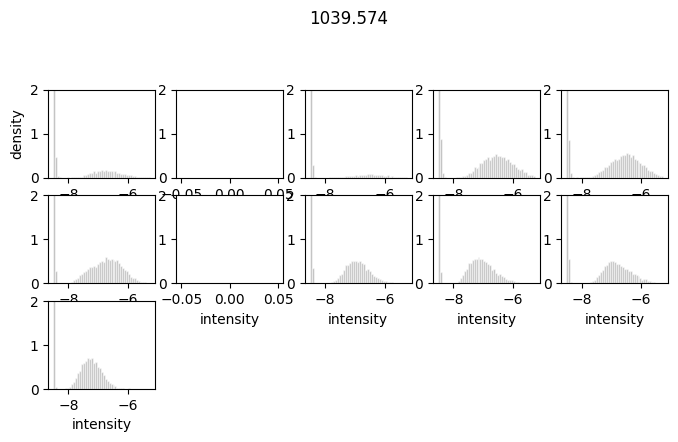

In [7]:
fig = plt.figure(None,(8,8), dpi=100)
gs = plt.GridSpec(6,5)
  
v = 7

def place_image(mask_list, tranformed_values, v, s, small_num):
    img = np.zeros(mask_list[s].shape).flatten()
    img[mask_list[s].flatten()] = np.exp(tranformed_values[:np.sum(mask_list[s]),s,v]) - small_num
    return img.reshape(mask_list[s].shape)


cm = plt.cm.get_cmap('bwr')
xmin, xmax = np.percentile(x[:,:,v][mask[:,:,v]], (0.1, 99.90))
xnew = np.linspace(xmin, xmax, 50)
vmax = np.exp(np.percentile(x[:,:,v][mask[:,:,v]], 99.9)) - small_num

for i, s in enumerate(range(S)):
    plt.subplot(gs[i])
    n, bins, patches = plt.hist(x[:,s,v][mask[:,s,v]], bins=xnew,
                                color="gray", alpha=0.6, density=True, edgecolor='w')
    plt.ylim([0,2])

    if i == 0:
        plt.ylabel('density')
    plt.xlabel('intensity')
    
plt.suptitle(np.array([float(x.split('/')[-1]) for x in PATH_MZ])[v])

plt.show()

# Normalization!

In [8]:
init_state = MAIA.norm.initialize(x, mask, visualize=False, subsample=True)
svi_result = MAIA.norm.normalize(x, 
                              mask,
                              init_state=init_state,
                              subsample=True,
                              optimizer=None,
                              num_steps=5000,
                              seed=42)
x_tran = MAIA.norm.transform(x, mask, svi_result)

GMM Initialization: 100%|██████████| 554/554 [00:19<00:00, 28.19it/s]
2023-09-01 16:59:30.234975: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 5000/5000 [00:08<00:00, 610.42it/s, init loss: 16922638.0000, avg. loss [4751-5000]: -907642.8125]


# Plot Results

#### A util module ?

In [9]:
weights = svi_result.params['weights_auto_loc']
locs = svi_result.params['locs_auto_loc']
scale1 = svi_result.params['scale1_auto_loc']
sigma_v = svi_result.params['sigma_v_auto_loc']
b_lambda = svi_result.params['b_lambda_auto_loc']
b_gamma = svi_result.params['b_gamma_auto_loc']
delta = svi_result.params['delta_auto_loc']
sigma_s = svi_result.params['sigma_s_auto_loc']
error = svi_result.params['error_auto_loc']
delta_ = svi_result.params['delta_']
loc0_delta = svi_result.params['loc0_delta']

In [10]:
n_cov = 1

#### A plotting module

molecule susceptibility: -0.10


/tmp/ipykernel_388431/2764077377.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('bwr')
/home/alireza/miniconda3/envs/myenv/lib/python3.11/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


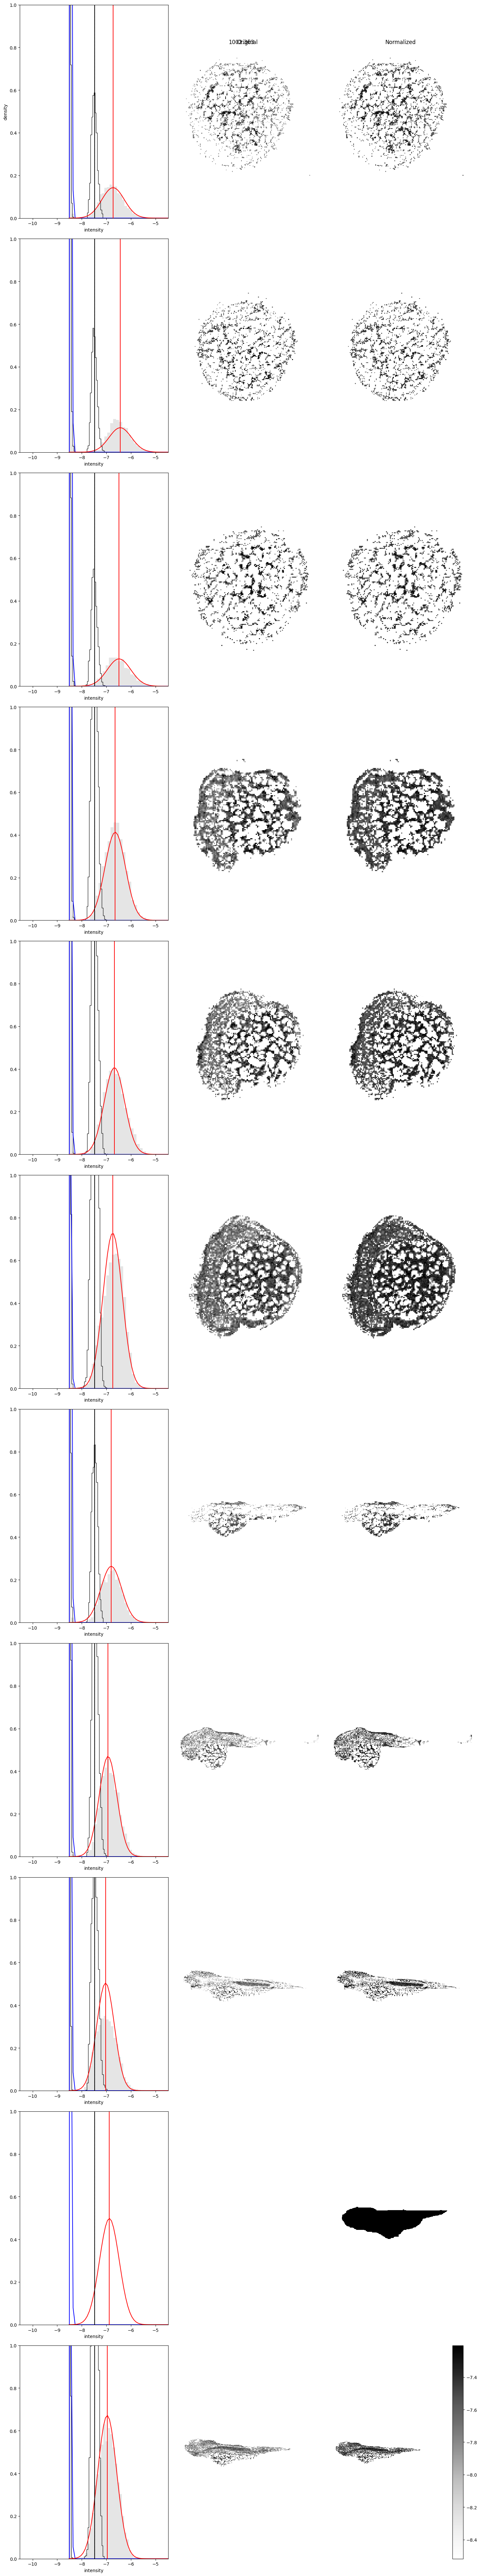

In [11]:
fig = plt.figure(None,(15,80))
gs = plt.GridSpec(S,3)
  
    
v = 1

#100, 22

print(f'molecule susceptibility: {b_lambda[v].mean():.2f}')
def place_image(mask_list, tranformed_values, v, s, small_num):
    img = np.zeros(mask_list[s].shape).flatten()
    #img[mask_list[s].flatten()] = np.exp(tranformed_values[:np.sum(mask_list[s]),s,v]) - small_num
    img[mask_list[s].flatten()] = tranformed_values[:np.sum(mask_list[s]),s,v]
    img[~mask_list[s].flatten().astype(bool)] = small_num
    return img.reshape(mask_list[s].shape)

cm = plt.cm.get_cmap('bwr')
xmin, xmax = np.percentile(x[:,:,v][mask[:,:,v]], (0.1, 99.90))
xmax += 1.
xnew = np.linspace(xmin, xmax, 50)
# vmax = np.exp(np.percentile(x[:,:,v][mask[:,:,v]], 99.9)) - small_num
# 

vmax_raw = np.percentile(x[:,:,v][mask[:,:,v]], 99.5)
vmax_trans = np.percentile(x_tran[:,:,v][mask[:,:,v]], 99.5)

for i, s in enumerate(range(S)):
    plt.subplot(gs[i,0])
    # try:
    #     #plt.title(f'section: {s}, sens: {b_gamma[s][0]:.2f}, lambda sum: {b_lambda[v]:.2f}, batch_factor: {(b_gamma[s]*b_lambda[v]):.2f}')
    # except:
        #plt.title(f'section: {s}, sens: {b_gamma[s]:.2f}, lambda sum: {b_lambda[v]:.2f}, batch_factor: {(b_gamma[s]*b_lambda[v]):.2f}')
    plt.hist(x[:,s,v][mask[:,s,v]], bins=30, density=True,color='gray', alpha=0.2)
    plt.hist(x_tran[:,s,v][mask[:,s,v]], bins=30, density=True,color='k',histtype='step', alpha=0.9)
    plt.axvline(locs[v], c="b")
    plt.plot(xnew, weights[s,v][0] * scipy.stats.norm(locs[v], scale1[v]).pdf(xnew), "b")

    # foreground distribution
    try:
        plt.axvline(locs[v] + delta_[s,v] + b_gamma[s] * b_lambda[v] + error[s,v] + loc0_delta, c="red")
        plt.plot(xnew, weights[s,v][1] * scipy.stats.norm(locs[v] + delta_[s,v] + b_gamma[s] * b_lambda[v]+ error[s,v] + loc0_delta,
                                                      sigma_v[v] + sigma_s[s]).pdf(xnew), "red")
    except:
        print('delta')
        plt.axvline(locs[v] + delta[v] + b_gamma[s] * b_lambda[v] + loc0_delta, c="red")
        plt.plot(xnew, weights[s,v][1] * scipy.stats.norm(locs[v]+ delta[v] + b_gamma[s] * b_lambda[v] + error[s,v] + loc0_delta,
                                                      sigma_v[v] + sigma_s[s]).pdf(xnew), "red")
    
    for c in range(n_cov):
        plt.axvline(np.unique(locs[v] + delta_[:,v])[c], c="black", alpha=0.5, linestyle='--')
    plt.axvline(locs[v] + delta_[s,v], c="black")
    
    plt.xlim(xmin-2., xmax)
    plt.ylim([0,1.])
    
    
    if i == 0:
        plt.ylabel('density')
    plt.xlabel('intensity')
    
    plt.subplot(gs[i,1])
    
    img = place_image(masks, x, v, s, np.log(small_num))
    #print(x[:,s,v][mask[:,s,v]].sum())
    plt.imshow(img, cmap='Greys', interpolation='none',vmax=vmax_raw, vmin=np.log(small_num))
    plt.axis('off')
    if i == 0:
        plt.title('Original')
        
    plt.subplot(gs[i,2])
    img = place_image(masks, x_tran, v, s, np.log(small_num))
    plt.imshow(img, cmap='Greys', interpolation='none',vmax=vmax_trans, vmin=np.log(small_num))
    plt.axis('off')
    if i == 0:
        plt.title('Normalized')
    
plt.colorbar()
plt.suptitle(np.array([float(x.split('/')[-1]) for x in PATH_MZ])[v])
plt.tight_layout()
plt.show()